## 08. PyTorch Paper Replicating

### Milestone Project 2: PyTorch Paper Replicating

=> replicating a Machine Learning research paper and creating a Vision Transformer(ViT) from scrach using PyTorch.

#### • What is paper replicating?

=> many of advances get published in machine learning research papers.

**=> Goal of paper replicating:** take replicate advances with code -> use the techniques for own problem

**=> Involves:** *turn a machine learning paper comprised of images/digrams, math and test into usable code and in this case, usable PyTorch code. Digram, math equations and test from the `ViT paper.`*

#### • What is a machine learning research paper?
> (1) **Abstract** -> An overview/summary of the paper's main findings/contributions
>
> (2) **Introduction** -> What's the paper's main problem and details of previous methods used to try and solve it.
>
> (3) **Method** -> How did the researchers go about conducting their research? -> what model(s), data sources, training setups were used?
>
> (4) **Results** -> outcomes -> If a new type of model or training setup was used, how did the results of findings compare to previous works?
>
> (5) **Conclusion** -> limitations of the suggested methods? next steps for the research community?
>
> (6) **References** -> resources/other papers did the researchers look at to build their own body of work?
>
> (7) **Appendix** -> any extra resources/findings to look at
>


#### • Where to find code examples for ML research paper?
> (1) **arXiv** -> a free and open resource for reading technical articles on everything from physics to computer science
>
> (2) **AK Twitter** -> The AK Twitter account publishes machine learning research highlights, often with live demos almost every day
>
> (3) **Paper with Code** -> collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.
>
> (4) **lucidrains' `vit-pytorch` GitHub repository** -> Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale and with a specific focus looks like. 
>
> ...

### 0. Get Setup

=> replicate the machine learning research paper `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale` (ViT paper) with PyTorch - https://arxiv.org/abs/2010.11929

=> The `Transformer neural network architecture` was originally introduced in the machine learning research paper `Attention is all you need` - https://arxiv.org/abs/1706.03762

=> A `Transformer architecture` is generally considered to be any neural network that uses the `attention mechanism` as its **primary learning layer**. Similar to a how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

=> the `Vision Transformer (ViT) architecture` was designed to adapt the original Transformer architecture to vision problem(s)

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [2]:
from go_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

device = "gpu" if torch.cuda.is_available() \
    else "mps" if torch.backends.mps.is_built() else "cpu"
device

'mps'

### 1. Get Data

=> continue on with FoodVision Mini -> still use the pizza, steak, sushi image dataset

In [3]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2. Create Dtasets and DataLoaders

=> use the `create_dataloaders()` function in `data_setup.py`.

• the training resolution is mentioned as being 224 (height=224, width=224)

In [5]:
from go_modular import data_setup
from torchvision import transforms

# Create image size -> comes from Table 3 of the ViT paper
IMG_SIZE = 224

# Create transforms pipline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32

# create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [7]:
# get a single image and label from a batch of data and inspect their shapes

# get a batch of images
img_batch, label_batch = next(iter(train_dataloader))

# get a single image and label
img, label = img_batch[0], label_batch[0]

# view the shape
img.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

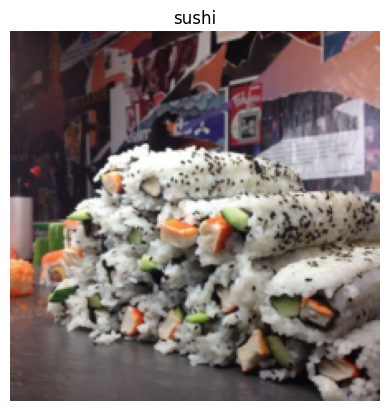

In [8]:
# plot the image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

### 3. Replicating the ViT paper

=> Terms:
- **Inputs** -> what goes into the model
- **Outputs** -> what comes out of the model/layer/block
- **Layer** -> takes an input, performs a function on it, returns an output
- **Block** -> a collection of layers
- **Architecture (mdoel)** -> a collection of blocks

#### 3.1 ViT Overview

- **Figure 1**: Visual overview of the architecture
- **Four equations** in Section 3.1: math equations which define the functions of each layer/block (mathematical grounding to the coloured blocks in Figure 1)
- **Table 1/3**: different hyperparameters for the architecture/training -> focused on the smallest version, ViT-Base
- Text descriptions (especially section 3.1)

##### 3.1.1 Figure 1

<img src="images/08-vit-paper-figure-1.png" width=700 alt="figure 1 from vision transformer paper"/>

- Embedding = learnable representation (start with random numbers and improve over time) 

**The ViT architecture is comprised of several stages:**
> • **Patch + Position Embedding (inputs)** - turns the input image into a sequence of images patches and add a position number what order the patch comes in
>
> • **Linear projection of flatterned patched (Embedded Patched)** - the image patched get turned into an *embedding* => benefit of embedding (rather than just image values) -> an embedding is a *learnable* representation of the image that can improving with training
>
> • **Norm** - (*Layer Normalization/LayerNorm*) - a technique for regularizing (reducing overfitting) a neural network -> `torch.nn.LayerNorm()`
>
> • **Multi-Head Attention** - (*Multi-Headed Self-Attention layer/MSA*) -> create an MSA layer via: `torch.nn.MultiheadAttention()`
>
> • **MLP(Multilayer perceptron)** - any collection of feedforward layers => contains two `torch.nn.Linear()` layers with a `torch.nn.GELU()` non-linearity activation in between them, and a `torch.nn.Dropout()` layer after each
>
> • **Transformer Encoder** - a collection of the layers listed above. => *2 skip connections* inside the Transformer encoder (the "+" symbols) -> the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
>
> • **MLP Head** (the classifier head) - the *output layer* of the architecture => converts the learned features of an input to a class output. => the structure of the MLP Head is similar to the MLP block
>



**Take Figure 1 and adapt it to FoodVision Mini problem of classifing images of food**

<img src="images/08-vit-paper-figure-1-food-mini.png" width=700 alt="adapt figure 1 to Food Mini"/>

##### 3.1.2 Four Equations

=> represent the math behind the four major parts of the ViT architecture

<img src="images/08-vit-paper-four-equations.png" width=700 alt="adapt figure 1 to Food Mini"/>

> `Equation(1):` The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where \
> • $(H, W)$ is the *resolution of the original image*, \
> • $C$ is the *number of channels*, \
> • $(P, P)$ is the *resolution of each image patch*, \
> • $N=H W / P^{2}$ is the *resulting number of patches*, which also serves as the effective input sequence length for the Transformer. 
> 
> -> The Transformer uses **constant latent vector size $D$** through all of its layers, \
> -> so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1) -> refer to the output of this projection as the patch embeddings.
> 
> => **Position embeddings** are added to the **patch embeddings** to *retain positional information*. \
> => use standard learnable $1 \mathrm{D}$ position embeddings -> since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.
> 
> \
> **=> In pseudocode:**
>
> ```python
> # Equation 1
> x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
> ```
> 


> `Equation(2)&(3):` The Transformer encoder (Vaswani et al., 2017) consists of *alternating layers of multiheaded selfattention* (*MSA*, see Appendix A) and *MLP blocks*(Eq. 2, 3). \
> **Layernorm (LN) is applied before every block**, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).
>
> \
> **=> In pseudocode:**
> ```python
> # Equation 2 
> x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
>
> # Equation 3 
> x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
> ```
>

> `Equation(4):` Similar to BERT's [ class ] token. \
> => prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, \
> whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). \
> => Both during *pre-training* and *fine-tuning*, a classification head is attached to $\mathbf{z}_{L}^{0}$. \
> => The classification head is implemented by a *MLP* with \
> • one hidden layer at pre-training time \
> • and by a single linear layer at fine-tuning time.
>
> * MLP = multilayer perceptron = a neural network with X number of layers
> * MLP = one hidden layer at training time
> * MLP = single linear layer at fine-tuning time 
>
> 
> **=> In pseudocode:**
> ```python
> # Equation 4 
> y = Linear_layer(LN_layer(x_output_MLP_block)) 
> ```

**Map to the ViT architecture in Figure 1**

<img src="images/08-vit-paper-map-equations-to-figure-1.png" width=700 alt="adapt figure 1 to Food Mini"/>

##### 3.1.3 Table 1

<img src="images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

> • **ViT-Base**, **ViT-Large** and **ViT-Huge** are all different sizes of the same model architecture
>
> • **ViT-B/16** = ViT-Base with image patch size 16x16 
>
> • **Layers** - the number of transformer encoder layers 
>
> • **Hidden size $D$** - the embedding size throughout the architecture
>
> • **MLP size** - the number of hidden units/neurons in the MLP
>
> • **Heads** - the number of multi-head self-attention 
>

### 4. Equation 1: Split data into patches and creating the class, position and patch embedding

#### 4.1 Calculate input and output shapes

- **Input shape:** $H\times{W}\times{C}$ (height x width x color channels)
- **Output shape:** ${N \times\left(P^{2} \cdot C\right)}$
- H = height, W = width, C = color channels, P = patch size
- N = number of patches = (height * width) / $p^{2}$
- D = constant latent vector size = embedding dimension (see Table 1)

In [9]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches
num_of_patches = int((height * width) / patch_size ** 2)
num_of_patches

196

In [10]:
# Input shape
embed_layer_input_shape = (height, width, color_channels)

# Output shape
embed_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embed_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embed_layer_output_shape} -> (num_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (num_of_patches, embedding_dimension)


#### 4.2 Turn a single image into patches

torch.Size([3, 224, 224])


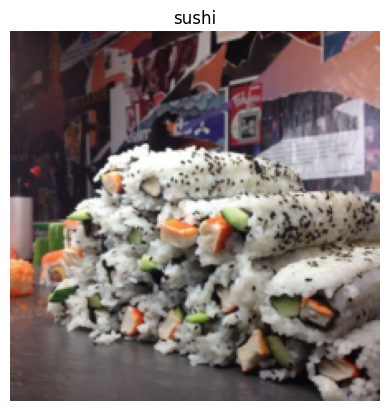

In [11]:
# View a single image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(img.shape)

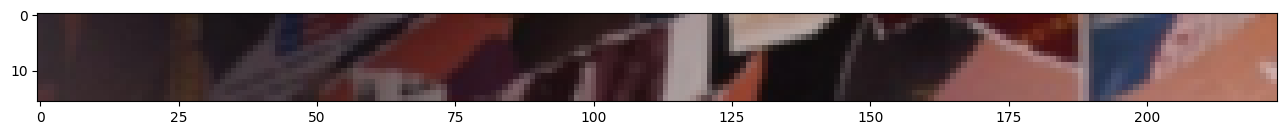

In [12]:
# get the top row of the image
img_permuted = img.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(img_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


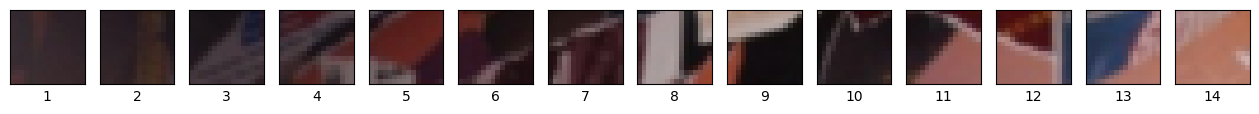

In [13]:
# plot top row as patches
row_size = 224
patch_size = 16
num_row_patches = row_size/patch_size 
assert row_size % patch_size == 0, "Row size must be divisible by patch size"
print(f"Number of patches per row: {num_row_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=row_size // patch_size,  # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

# iterate through number of patches in the top row
for i, patch in enumerate(range(0, row_size, patch_size)):
    axs[i].imshow(img_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


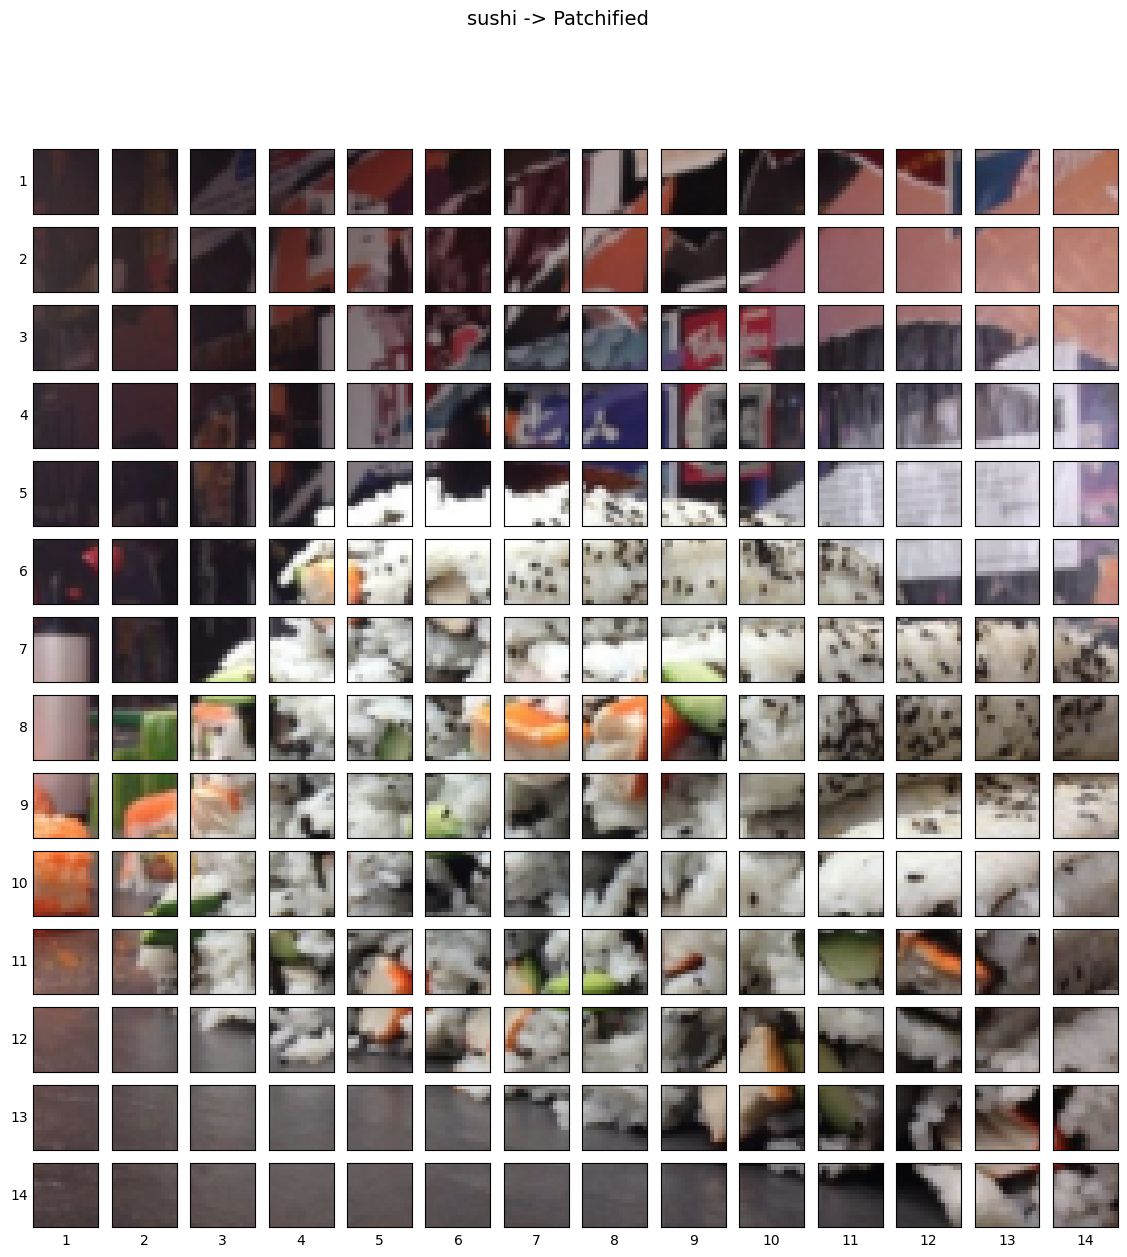

In [14]:
# try to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels")

# create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size ,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(num_patches, num_patches))

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(img_permuted[patch_height:patch_height+patch_size,
                                      patch_width:patch_width+patch_size,
                                      :])   # get all color channels
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set up a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()

#### 4.3 Create image patches and turn them into patch embeddings

=> create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and set the kernel size and stride parameters to `patch_size`

In [15]:
from torch import nn

# Set the patch size 
patch_size = 16

# Create a conv2d lyaer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,       # for color images
                   out_channels=768,    # D size from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [16]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(img.unsqueeze(0)) # add batch dimension
print(image_out_of_conv.shape) 

torch.Size([1, 768, 14, 14])


In [17]:
image_out_of_conv.requires_grad

True

Showing random convolutional feature maps from indexes: [292, 425, 182, 83, 427]
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])
torch.Size([1, 14, 14])


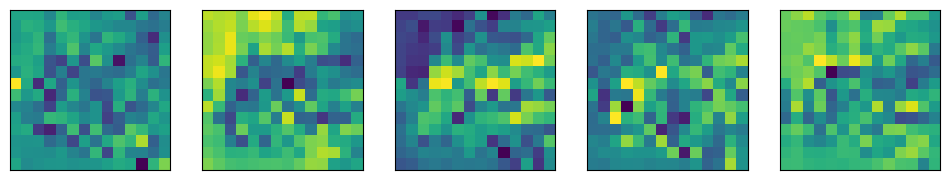

In [18]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    # index on the output tensor of the conv2d layer
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    print(image_conv_feature_map.shape)
    # remove batch dimension
    # and remove from grad tracking/switch to numpy for matplotlib
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0240, -0.0511, -0.0285, -0.0895, -0.0195, -0.0706, -0.0420,
            0.0824,  0.1775, -0.0606, -0.0859, -0.1290, -0.0539,  0.0042],
          [-0.0427, -0.0239, -0.0194,  0.0023,  0.1524, -0.0408, -0.0748,
            0.0729, -0.0083, -0.1481, -0.0050, -0.0218, -0.0131, -0.0036],
          [-0.0151, -0.0157,  0.0232, -0.0866,  0.0060, -0.0799, -0.1223,
           -0.0026, -0.1682,  0.0494,  0.1310, -0.0038, -0.0024, -0.0416],
          [-0.0220, -0.0164, -0.0369, -0.0408, -0.0803, -0.0241, -0.0531,
           -0.0167, -0.0019, -0.0725, -0.0869, -0.1475, -0.0180, -0.1527],
          [-0.0305, -0.0287, -0.0128, -0.0295, -0.4289, -0.3371, -0.3946,
           -0.4337, -0.2134, -0.3602,  0.0593,  0.0267, -0.0028, -0.0897],
          [ 0.0155,  0.0108, -0.0656,  0.1205,  0.2409,  0.1179,  0.0602,
           -0.1677,  0.0609, -0.1125,  0.0742,  0.2568,  0.2287,  0.0144],
          [-0.0225, -0.0398, -0.3385, -0.0008,  0.0210,  0.0107, -0.0999,
           -0.3396, -0.0288,  0.

#### 4.4 Flatten the patch embedding with `torch.nn.Flatten()`

=> current shape: [1, 768, 14, 14]

=> want: **(batch_size, num_of_patches, embedding_dim)**

=> only want to flatten the "**spatial dimensions of the feature map**" -> the `feature_map_height` and `feature_map_width` dimensions of `image_out_of_conv`

In [20]:
from torch import nn
# create a flatten layer
flatten_layer = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                           end_dim=3)   # flatten feature_map_width (dimension 3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
torch.Size([1, 196, 768]) -> (batch_size, num_of_patches, embedding_dimension)


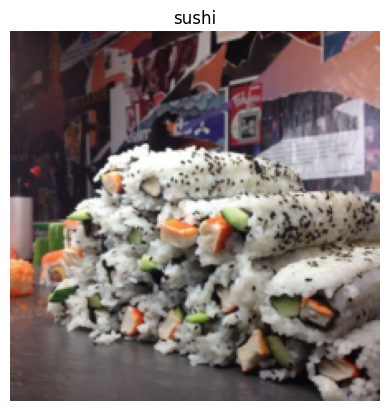

In [21]:
# put all together
# view single image
plt.imshow(img.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {img.shape}")

# turn into feature maps
image_out_of_conv = conv2d(img.unsqueeze(0)) # add batch dimension
print(f"Image feature map shape: {image_out_of_conv.shape}")

# flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

# rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened_permuted.shape} -> (batch_size, num_of_patches, embedding_dimension)")

(-0.5, 195.5, 0.5, -0.5)

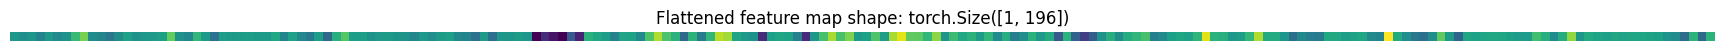

In [22]:
# visualize a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

#### 4.5 Turn the ViT patch embedding layer into a PyTorch module

We want this module to do a few things: \
(1). Create a class called `PatchEmbedding` that inherits from `nn.Module`. \
(2). Initialize with appropriate hyperparameters -> channels, embedding dimension, patch size. \
(3). Create a layer to turn an image into embedded patches using `nn.Conv2d()`. \
(4). Create a layer to `flatten` the feature maps of the output of the layer in 3. \
(5). Define a `foward()` that defines the forward computation. \
(6). Make sure the output shape of the layer reflects the required output shape of the patch embedding -> ${N \times\left(P^{2} \cdot C\right)}$

In [23]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()

        # layer to turn into patches
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels = embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)
        # layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)

In [24]:
torch.manual_seed(42)

# create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image through
print(f"Input image shape: {img.unsqueeze(0).shape}")
patch_embedded_img = patchify(img.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_img.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [25]:
random_input_image = (1, 3, 224, 224)

# will error because image size is incompatible with patch_size
# random_input_image_error = (1, 3, 250, 250)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#### 4.6 Creating the class token embedding

=> get to work on the class token embedding -> ${X_{class}}$ from equation 1.

\
=> In pseudocode:
```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
# the concatenation happens on dim=1 (the number_of_patches dimension)
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
```

\
=> will get the batch size and embedding dimension shape and then create a `torch.ones()` tensor in the shape `[batch_size, 1, embedding_dimension]` \
=> in reality => may create the class token embedding with `torch.randn()`

=> and make the tensor learnable by passing it to `nn.Parameter()` with `require_grad=True`

In [27]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_img.shape[0]            # 1
embedding_dimension = patch_embedded_img.shape[-1]  # 768

# Create class token embedding as a learnable parameter that shares the same
# size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

print(f"Shape of the class_token: {class_token.shape} " \
       "-> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Shape of the class_token: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


`number_of_tokens` -> 1 => since only want to prepend one class token value to the start of the patch embedding sequence


In [29]:
# add class token embedding to the front of the patch embedding
patch_with_class = torch.cat((class_token, patch_embedded_img),
                             dim=1)     # concat on 1st dimension

print(patch_with_class)
print(f"Sequence of patch embeddings with class token prepended shape:\n" \
      f"{patch_with_class.shape} " \
      f"-> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1923,  0.0102, -0.0742,  ...,  0.1512, -0.0789,  0.0827],
         [-0.1951, -0.0160, -0.0600,  ...,  0.1413, -0.0804,  0.0414],
         ...,
         [-0.5913,  0.2441,  0.0677,  ...,  0.3303, -0.2150, -0.0175],
         [-0.2717,  0.0294, -0.3839,  ...,  0.2838, -0.1246,  0.4697],
         [-0.5201,  0.1673, -0.1228,  ...,  0.2707, -0.1276,  0.1437]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape:
torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


##### => Review:

<img src="images/08-vit-paper-equation-1-prepend-class-token.png" width=700 alt="Prepend learnable class token"/>

#### 4.7 Create the position embedding

=> add learnable 1D set of position embeddings to `[class_token, patch embedding]` \
-> ${E_{pos}}$ in equation 1, where $E$ stands for 'embedding'

=> position embedding **shape**: [num_patches + 1, embedding_dim] -> ${E_{pos}} \in R^{(N + 1) \times D}$

In [30]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_with_class.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the
# shape of the position embedding
print(position_embedding[:, :10, :10])

print(f"Position embeddding shape: {position_embedding.shape} " \
      f"-> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [31]:
# add the position embedding to the patch_with_class
patch_and_position_embedding = patch_with_class + position_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings " \
      f"added shape: \n {patch_and_position_embedding.shape} " \
      f"-> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8077, 1.0102, 0.9258,  ..., 1.1512, 0.9211, 1.0827],
         [0.8049, 0.9840, 0.9400,  ..., 1.1413, 0.9196, 1.0414],
         ...,
         [0.4087, 1.2441, 1.0677,  ..., 1.3303, 0.7850, 0.9825],
         [0.7283, 1.0294, 0.6161,  ..., 1.2838, 0.8754, 1.4697],
         [0.4799, 1.1673, 0.8772,  ..., 1.2707, 0.8724, 1.1437]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: 
 torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


##### => Review:

<img src="images/08-vit-paper-equation-1-patch-with-class-token-and-position.png" width=700 alt="Prepend position embedding"/>

#### 4.8 Put it all together: from image to embedding

$z_0 = [x_{class}; x^{1}_pE; x^{2}_pE; ... ; x^{N}_pE] + E_{pos}, $

$E \in R^{(P^2 • C) \times D}, E_{pos} \in R^{(N+1) \times D}$

In [33]:
torch.manual_seed(42)

# set patch size
patch_size = 16

# print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {img.shape}")
height, width = img.shape[1], img.shape[2]

# get the image tensor and add batch dimension
x = img.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# create position embedding
number_of_patches = int((height * width) / patch_size ** 2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# add position embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
